In [236]:
from linearmodels.panel import PooledOLS, PanelOLS

import statsmodels.api as sm
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from statsmodels.iolib.summary2 import summary_col

## Read in data

In [237]:
us_daily = pd.read_csv("data/cleaned/daily_df.csv", index_col=0)
us_daily["date"] = pd.to_datetime(us_daily["date"])
us_daily = us_daily.set_index("date")

In [238]:
us_monthly = us_daily.groupby([pd.Grouper(freq='M'), 'state']).mean()
us_monthly
us_monthly = pd.DataFrame(us_monthly.to_records())

In [239]:
micperceptions = pd.read_csv("data/cleaned/misperception_state_inferred.csv", index_col=0)
micperceptions = pd.DataFrame(micperceptions.to_records())
micperceptions.columns = ["state", "pc_misperception"]
micperceptions.pc_misperception = micperceptions.pc_misperception.str.rstrip('%').astype('float') / 100.0

In [240]:
us_cross_sectional = us_daily.loc[(us_daily.index >= "2020-03-01") & (us_daily.index <= "2021-01-31")].groupby(["state"]).mean()
us_Aug = us_daily.loc[(us_daily.index >= "2020-08-01") & (us_daily.index <= "2021-08-31")].groupby(["state"]).mean()

In [241]:
us_cross_sectional = pd.merge(us_cross_sectional, micperceptions, on="state")
us_Aug = pd.merge(us_Aug, micperceptions, on="state")

In [242]:
reported_compliance = pd.read_csv("data/covidstates/beh_2.csv", index_col=0)

US_state_abb = pd.read_csv("data/US_state_abb.csv")
US_state_abb.columns = ["state", "state_abb"]
reported_compliance = pd.merge(reported_compliance, US_state_abb, on="state_abb", how="left")

In [243]:
reported_compliance.columns = ["state_abb", "not_at_all", "not_very", "somewhat", "very", "error_margin", "N", "wave", "state"]

### Misinformation index

In [244]:
news_source = pd.read_csv("data/news_source.csv", index_col=0)
news_source = news_source.rename({'state': 'state_abb'}, axis=1)

source_false_prop = pd.read_csv("data/Source_false_prop.csv", index_col=0)

news_source = pd.merge(news_source, US_state_abb, on="state_abb", how="left")

In [245]:
news_source["misperception_index"] = 0

In [246]:
source_false_prop

,Friends and family,Radio news,Podcasts,Local television,"Network television (e.g. ABC, CBS, or NBC)","Cable television (e.g. CNN, Fox News, or MSNBC)",Late-night comedy shows (e.g. The Late Show with Stephen Colbert or The Daily Show),Print newspapers (e.g. the New York Times or the Wall Street Journal print edition),A news website or app (e.g. the New York Times or Fox News websites or apps),A health website or app (e.g. WebMD),...,Snapchat (website or app),Wikipedia (website or app),Error Margin.1,N.1,CNN,Fox News,MSNBC,President Trump’s press briefings,Error Margin.2,N.2
source,,,,,,,,,,,,,,,,,,,,,
false_percentage,0.13,0.14,0.18,0.11,0.12,0.12,0.16,0.12,0.11,0.17,...,0.26,0.25,NaN,NaN,0.16,0.18,0.15,0.18,NaN,NaN


In [248]:
sources = [
    "Friends and family",
    "Radio news",
    "Podcasts",
    "Local television",
    "Network television (e.g.  ABC, CBS, or NBC)",
    "Late-night comedy shows (e.g. The Late Show with Stephen Colbert or The Daily Show)",
    "Print newspapers (e.g. the New York Times or the Wall Street Journal print edition)",
    "A news website or app (e.g. the New York Times or Fox News websites or apps)",
    "A health website or app (e.g. WebMD)",
    "A government website or app (e.g. CDC.gov)",
    "An organization website or app (e.g. WHO.int)",
    "A search engine website or app (e.g. Google, Bing)",
    "Facebook (website or app)",
    "Twitter (website or app)",
    "Youtube(website or app)",
    "Reddit (website or app)",
    "Instagram (website or app)",
    "Snapchat  (website or app)",
    "Wikipedia (website or app)",
    "CNN",
    "Fox News",
    "MSNBC",
    "President Trump’s press briefings",
]

In [249]:
source = "Friends and family"

In [250]:
index = news_source["misperception_index"]
for source in sources:
    index = index + news_source[source] * float(source_false_prop[source])
news_source["misperception_index"] = index
news_misperception = news_source[["state", "wave", "misperception_index"]]


In [251]:
reported_compliance_cross_sectional = reported_compliance.groupby(["state"]).mean()
news_misperception_cross_sectional = news_misperception.groupby(["state"]).mean()

us_cross_sectional = pd.merge(us_cross_sectional, reported_compliance_cross_sectional, on="state", how="left")
us_cross_sectional = pd.merge(us_cross_sectional, news_misperception_cross_sectional, on="state", how="left")

reported_compliance_Aug = reported_compliance.loc[reported_compliance["wave"] == 9].groupby(["state"]).mean()
news_misperception_Aug = news_misperception.loc[news_misperception["wave"] == 9].groupby(["state"]).mean().drop("wave", axis = 1)

In [252]:
us_Aug = pd.merge(us_Aug, reported_compliance_Aug, on="state", how="left")
us_Aug = pd.merge(us_Aug, news_misperception_Aug, on="state", how="left")

In [253]:
reported_compliance_Aug.columns

Index(['not_at_all', 'not_very', 'somewhat', 'very', 'error_margin', 'N',
       'wave'],
      dtype='object')

## Disease outcomes

In [254]:
us_cross_sectional["deaths_pth"] = 1000 * us_cross_sectional["deathIncrease"] / us_cross_sectional["pop_2019"]
us_Aug["deaths_pth"] = 1000 * us_Aug["deathIncrease"] / us_Aug["pop_2019"]

In [255]:
us_cross_sectional["hospitalized_pth"] = 1000 * us_cross_sectional["hospitalizedIncrease"] / us_cross_sectional["pop_2019"]
us_Aug["hospitalized_pth"] = 1000 * us_Aug["hospitalizedIncrease"] / us_Aug["pop_2019"]

In [256]:
us_cross_sectional["positivity_rate"] = us_cross_sectional["positiveIncrease"] / us_cross_sectional["totalTestResultsIncrease"]
us_Aug["positivity_rate"] = us_Aug["positiveIncrease"] / us_Aug["totalTestResultsIncrease"]

There is generally positive relationship between the level of misperceptions and severity of disease outcomes. 

In [271]:
cross_sectional_reg_1_posrate = smf.ols('positivity_rate ~ pc_misperception + misperception_index', data=us_cross_sectional).fit()
cross_sectional_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     4.395
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0178
Time:                        07:59:26   Log-Likelihood:                 75.901
No. Observations:                  50   AIC:                            -145.8
Df Residuals:                      47   BIC:                            -140.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2037      0.126      1.613      0.113      -0.050       0.458
pc_misperception        1.1613      0.427      2.721      0.009       0.303       2.020
misperception_index    -0.0047      0.002     -2.014      0.050      -0.009   -4.29e-06
==============================================================================
Omnibus:                       21.873   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.991
Skew:                           1.479   Prob(JB):                     1.13e-07
Kurtosis:                       5.571   Cond. No.                     3.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [272]:
Aug_reg_1_posrate = smf.ols('positivity_rate ~ pc_misperception + misperception_index', data=us_Aug).fit()
Aug_reg_1_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     5.150
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00950
Time:                        07:59:55   Log-Likelihood:                 64.558
No. Observations:                  50   AIC:                            -123.1
Df Residuals:                      47   BIC:                            -117.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3150      0.146      2.157      0.036       0.021       0.609
pc_misperception        1.0366      0.507      2.045      0.047       0.017       2.056
misperception_index    -0.0068      0.003     -2.637      0.011      -0.012      -0.002
==============================================================================
Omnibus:                       27.596   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.799
Skew:                           1.745   Prob(JB):                     2.53e-11
Kurtosis:                       6.353   Cond. No.                     2.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [259]:
cross_sectional_reg_1_dea = smf.ols('deaths_pth ~ pc_misperception', data=us_cross_sectional).fit()
cross_sectional_reg_1_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.462
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0399
Time:                        07:58:47   Log-Likelihood:                 254.97
No. Observations:                  50   AIC:                            -505.9
Df Residuals:                      48   BIC:                            -502.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0005      0.002      0.339      0.736      -0.003       0.004
pc_misperception     0.0234      0.011      2.112      0.040       0.001       0.046
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.754
Skew:                           0.242   Prob(JB):                        0.686
Kurtosis:                       2.643   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [260]:
Aug_reg_1_dea = smf.ols('deaths_pth ~ pc_misperception', data=us_Aug).fit()
Aug_reg_1_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     9.159
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00397
Time:                        07:58:47   Log-Likelihood:                 244.14
No. Observations:                  50   AIC:                            -484.3
Df Residuals:                      48   BIC:                            -480.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0007      0.002     -0.377      0.708      -0.005       0.003
pc_misperception     0.0417      0.014      3.026      0.004       0.014       0.069
==============================================================================
Omnibus:                        0.554   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.662
Skew:                          -0.082   Prob(JB):                        0.718
Kurtosis:                       2.460   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
print(summary_col([cross_sectional_reg_1_posrate, cross_sectional_reg_1_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                  & positivity\_rate & deaths\_pth  \\
\hline
Intercept         & -0.024           & 0.001        \\
                  & (0.058)          & (0.002)      \\
pc\_misperception & 0.876**          & 0.023**      \\
                  & (0.415)          & (0.011)      \\
R-squared         & 0.085            & 0.085        \\
R-squared Adj.    & 0.066            & 0.066        \\
\hline
\end{tabular}
\end{center}
\end{table}


In [262]:
print(summary_col([Aug_reg_1_posrate, Aug_reg_1_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                  & positivity\_rate & deaths\_pth  \\
\hline
Intercept         & -0.022           & -0.001       \\
                  & (0.075)          & (0.002)      \\
pc\_misperception & 0.924*           & 0.042***     \\
                  & (0.536)          & (0.014)      \\
R-squared         & 0.058            & 0.160        \\
R-squared Adj.    & 0.039            & 0.143        \\
\hline
\end{tabular}
\end{center}
\end{table}


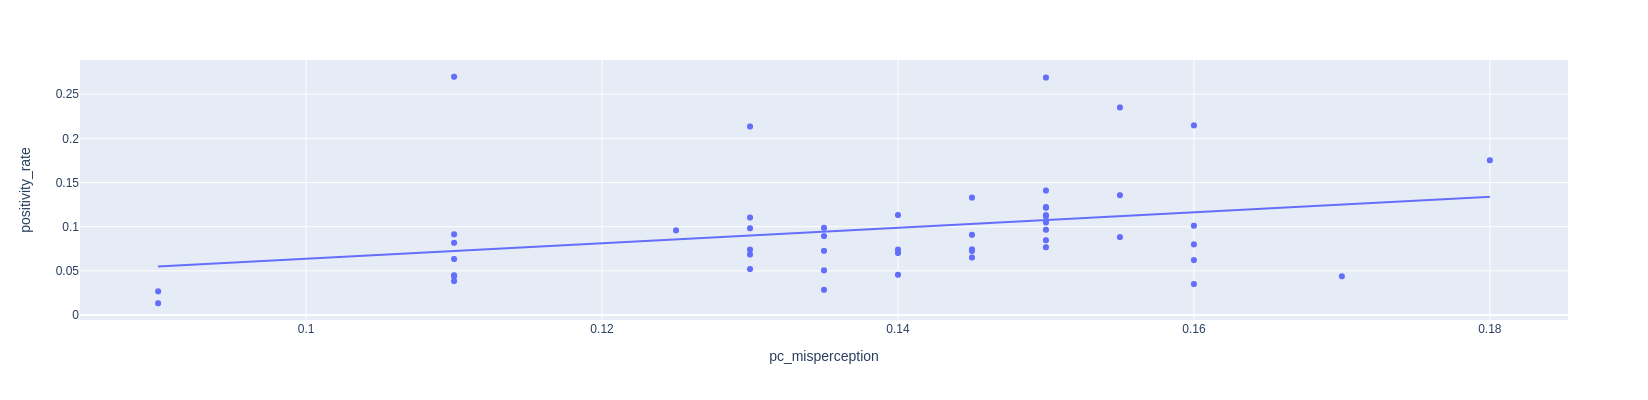

In [263]:
fig = px.scatter(us_cross_sectional, x="pc_misperception", y="positivity_rate", hover_data=["state"], trendline="ols", width=400, height=400)
fig.show()

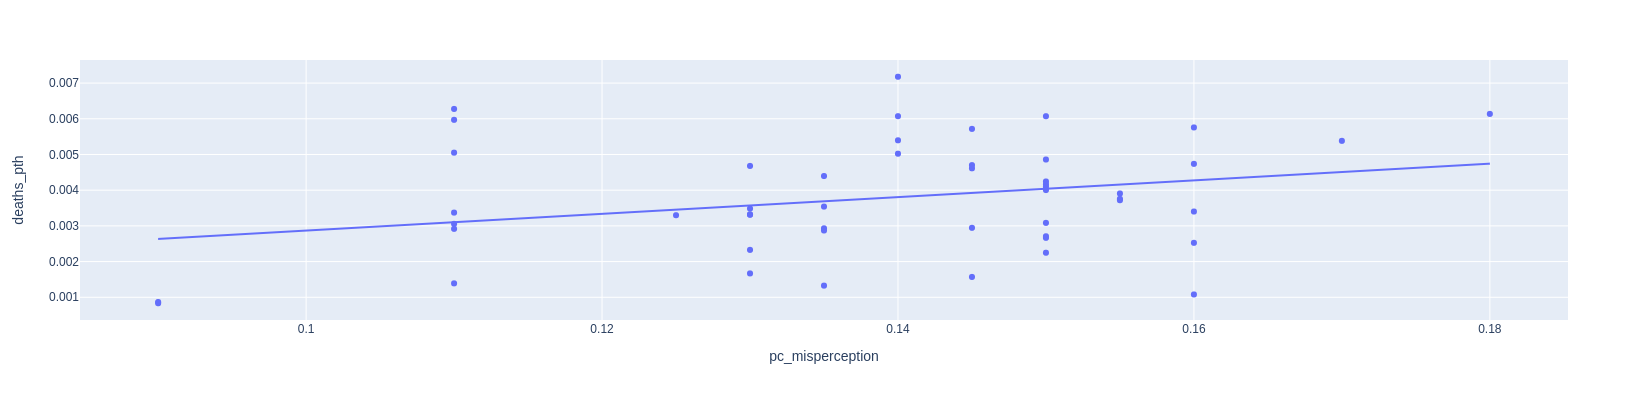

In [264]:
fig = px.scatter(us_cross_sectional, x="pc_misperception", y="deaths_pth", hover_data=["state"], trendline="ols", width=400, height=400)
fig.show()

In [274]:
cross_sectional_reg_2_posrate = smf.ols('positivity_rate ~ pc_misperception + StringencyIndex + White + misperception_index', data=us_cross_sectional).fit()
cross_sectional_reg_2_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     9.661
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           9.98e-06
Time:                        08:12:41   Log-Likelihood:                 87.112
No. Observations:                  50   AIC:                            -164.2
Df Residuals:                      45   BIC:                            -154.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2938      0.158      1.858      0.070      -0.025       0.612
pc_misperception        0.4344      0.377      1.152      0.256      -0.325       1.194
StringencyIndex        -0.0036      0.001     -5.040      0.000      -0.005      -0.002
White                  -0.0251      0.066     -0.380      0.706      -0.158       0.108
misperception_index    -0.0010      0.002     -0.435      0.665      -0.006       0.004
==============================================================================
Omnibus:                       28.463   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.469
Skew:                           1.623   Prob(JB):                     2.72e-14
Kurtosis:                       7.409   Cond. No.                     4.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [266]:
cross_sectional_reg_2_dea = smf.ols('deaths_pth ~ pc_misperception + StringencyIndex + White', data=us_cross_sectional).fit()
cross_sectional_reg_2_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.931
Date:                Sun, 21 Feb 2021   Prob (F-statistic):              0.138
Time:                        07:58:54   Log-Likelihood:                 255.71
No. Observations:                  50   AIC:                            -503.4
Df Residuals:                      46   BIC:                            -495.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0034      0.003      1.069      0.290      -0.003       0.010
pc_misperception     0.0188      0.012      1.587      0.119      -0.005       0.043
StringencyIndex  -2.651e-05   2.29e-05     -1.157      0.253   -7.26e-05    1.96e-05
White               -0.0011      0.002     -0.563      0.576      -0.005       0.003
==============================================================================
Omnibus:                        1.165   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                0.995
Skew:                           0.338   Prob(JB):                        0.608
Kurtosis:                       2.852   Cond. No.                     2.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [267]:
Aug_reg_2_posrate = smf.ols('positivity_rate ~ pc_misperception + StringencyIndex + White', data=us_Aug).fit()
Aug_reg_2_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     11.86
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           7.04e-06
Time:                        07:58:55   Log-Likelihood:                 73.931
No. Observations:                  50   AIC:                            -139.9
Df Residuals:                      46   BIC:                            -132.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2944      0.120      2.448      0.018       0.052       0.536
pc_misperception     0.1227      0.462      0.266      0.792      -0.807       1.053
StringencyIndex     -0.0040      0.001     -5.272      0.000      -0.006      -0.002
White               -0.0231      0.077     -0.300      0.765      -0.178       0.132
==============================================================================
Omnibus:                       24.797   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.691
Skew:                           1.550   Prob(JB):                     5.37e-10
Kurtosis:                       6.299   Cond. No.                     2.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [268]:
Aug_reg_2_dea = smf.ols('deaths_pth ~ pc_misperception + StringencyIndex + White', data=us_Aug).fit()
Aug_reg_2_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     7.900
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           0.000235
Time:                        07:58:56   Log-Likelihood:                 250.16
No. Observations:                  50   AIC:                            -492.3
Df Residuals:                      46   BIC:                            -484.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0049      0.004      1.371      0.177      -0.002       0.012
pc_misperception     0.0271      0.014      1.991      0.052      -0.000       0.054
StringencyIndex   -7.44e-05   2.24e-05     -3.316      0.002      -0.000   -2.92e-05
White               -0.0001      0.002     -0.055      0.956      -0.005       0.004
==============================================================================
Omnibus:                        0.780   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.826
Skew:                          -0.273   Prob(JB):                        0.662
Kurtosis:                       2.686   Cond. No.                     2.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [269]:
cross_sectional_reg_3_posrate = smf.ols('positivity_rate ~ pc_misperception + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.143
Date:                Sun, 21 Feb 2021   Prob (F-statistic):              0.108
Time:                        07:58:57   Log-Likelihood:                 74.885
No. Observations:                  50   AIC:                            -141.8
Df Residuals:                      46   BIC:                            -134.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0442      0.116     -0.382      0.704      -0.277       0.188
pc_misperception      0.8958      0.427      2.099      0.041       0.037       1.755
White                 0.0635      0.076      0.841      0.405      -0.089       0.216
Urbanization_rate    -0.0004      0.001     -0.741      0.463      -0.002       0.001
==============================================================================
Omnibus:                       21.404   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.318
Skew:                           1.439   Prob(JB):                     1.58e-07
Kurtosis:                       5.599   Cond. No.                     4.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [270]:
cross_sectional_reg_3_dea = smf.ols('deaths_pth ~ pc_misperception + White + Urbanization_rate', data=us_cross_sectional).fit()
cross_sectional_reg_3_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     2.572
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0655
Time:                        07:58:57   Log-Likelihood:                 256.63
No. Observations:                  50   AIC:                            -505.3
Df Residuals:                      46   BIC:                            -497.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0026      0.003     -0.866      0.391      -0.009       0.003
pc_misperception      0.0266      0.011      2.358      0.023       0.004       0.049
White                 0.0009      0.002      0.435      0.665      -0.003       0.005
Urbanization_rate   2.78e-05   1.58e-05      1.760      0.085      -4e-06    5.96e-05
==============================================================================
Omnibus:                        0.817   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.665   Jarque-Bera (JB):                0.832
Skew:                           0.119   Prob(JB):                        0.660
Kurtosis:                       2.415   Cond. No.                     4.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
cross_sectional_reg_4_posrate = smf.ols('positivity_rate ~ pc_misperception + White + Urbanization_rate + Percent_bachelor_or_higher', data=us_cross_sectional).fit()
cross_sectional_reg_4_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     2.849
Date:                Sun, 21 Feb 2021   Prob (F-statistic):             0.0345
Time:                        05:23:08   Log-Likelihood:                 77.258
No. Observations:                  50   AIC:                            -144.5
Df Residuals:                      45   BIC:                            -135.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0775      0.125      0.618      0.539      -0.175       0.330
pc_misperception               0.5040      0.451      1.117      0.270      -0.405       1.413
White                          0.0762      0.073      1.043      0.302      -0.071       0.223
Urbanization_rate              0.0002      0.001      0.252      0.802      -0.001       0.001
Percent_bachelor_or_higher    -0.0040      0.002     -2.117      0.040      -0.008      -0.000
==============================================================================
Omnibus:                       21.571   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.793
Skew:                           1.482   Prob(JB):                     2.06e-07
Kurtosis:                       5.450   Cond. No.                     4.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
cross_sectional_reg_4_dea = smf.ols('deaths_pth ~ pc_misperception + White + Urbanization_rate + Percent_bachelor_or_higher', data=us_cross_sectional).fit()
cross_sectional_reg_4_dea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deaths_pth   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1.931
Date:                Sun, 21 Feb 2021   Prob (F-statistic):              0.122
Time:                        05:23:08   Log-Likelihood:                 256.71
No. Observations:                  50   AIC:                            -503.4
Df Residuals:                      45   BIC:                            -493.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0020      0.003     -0.586      0.561      -0.009       0.005
pc_misperception               0.0246      0.012      1.972      0.055      -0.001       0.050
White                          0.0009      0.002      0.462      0.647      -0.003       0.005
Urbanization_rate           3.085e-05   1.78e-05      1.733      0.090      -5e-06    6.67e-05
Percent_bachelor_or_higher     -2e-05    5.2e-05     -0.385      0.702      -0.000    8.46e-05
==============================================================================
Omnibus:                        0.663   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.775
Skew:                           0.179   Prob(JB):                        0.679
Kurtosis:                       2.506   Cond. No.                     4.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
print(summary_col([cross_sectional_reg_4_posrate, cross_sectional_reg_4_dea],stars=True, float_format="%0.3f").as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                              & positivity\_rate & deaths\_pth  \\
\hline
Intercept                     & 0.078            & -0.002       \\
                              & (0.125)          & (0.003)      \\
pc\_misperception             & 0.504            & 0.025*       \\
                              & (0.451)          & (0.012)      \\
White                         & 0.076            & 0.001        \\
                              & (0.073)          & (0.002)      \\
Urbanization\_rate            & 0.000            & 0.000*       \\
                              & (0.001)          & (0.000)      \\
Percent\_bachelor\_or\_higher & -0.004**         & -0.000       \\
                              & (0.002)          & (0.000)      \\
R-squared                     & 0.202            & 0.146        \\
R-squared Adj.                & 0.131            & 0.071        \\
\hline
\end{tabular}
\end{center}
\end{table}

Nothing really interesting here. 

## Relationship between misperception and mobility

In [97]:
cross_sectional_reg_5_posrate = smf.ols("very ~ pc_misperception + StringencyIndex", data=us_cross_sectional).fit()
cross_sectional_reg_5_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   very   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     18.91
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           9.42e-07
Time:                        06:44:22   Log-Likelihood:                -145.68
No. Observations:                  50   AIC:                             297.4
Df Residuals:                      47   BIC:                             303.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           35.3924      6.583      5.377      0.000      22.150      48.635
pc_misperception    61.4958     35.016      1.756      0.086      -8.946     131.938
StringencyIndex      0.4070      0.066      6.147      0.000       0.274       0.540
==============================================================================
Omnibus:                        2.577   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                1.993
Skew:                          -0.488   Prob(JB):                        0.369
Kurtosis:                       3.071   Cond. No.                     2.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
Aug_reg_5_posrate = smf.ols("very ~ pc_misperception + StringencyIndex", data=us_Aug).fit()
Aug_reg_5_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   very   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     24.53
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           5.06e-08
Time:                        06:44:30   Log-Likelihood:                -155.20
No. Observations:                  50   AIC:                             316.4
Df Residuals:                      47   BIC:                             322.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           20.1052      7.634      2.634      0.011       4.748      35.462
pc_misperception   116.9799     43.068      2.716      0.009      30.338     203.622
StringencyIndex      0.4787      0.069      6.980      0.000       0.341       0.617
==============================================================================
Omnibus:                        0.925   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.630   Jarque-Bera (JB):                0.294
Skew:                           0.063   Prob(JB):                        0.863
Kurtosis:                       3.354   Cond. No.                     2.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
cross_sectional_reg_6_posrate = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misperception + Urbanization_rate + AverageTemperature",
    data=us_cross_sectional,
).fit()
cross_sectional_reg_6_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.568
Model:                                                      OLS   Adj. R-squared:                  0.540
Method:                                           Least Squares   F-statistic:                     20.19
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           1.71e-08
Time:                                                  05:29:13   Log-Likelihood:                -175.45
No. Observations:                                            50   AIC:                             358.9
Df Residuals:                                                46   BIC:                             366.5
Df Model:                                                     3                                         
Covariance Type:                                      nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             35.5394     11.310      3.142      0.003      12.773      58.305
pc_misperception      35.0534     65.447      0.536      0.595     -96.685     166.792
Urbanization_rate     -0.4383      0.086     -5.071      0.000      -0.612      -0.264
AverageTemperature    -1.1558      0.268     -4.312      0.000      -1.695      -0.616
==============================================================================
Omnibus:                        0.172   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.918   Jarque-Bera (JB):                0.343
Skew:                          -0.108   Prob(JB):                        0.843
Kurtosis:                       2.657   Cond. No.                     4.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
Aug_reg_6_posrate = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misperception + Urbanization_rate + AverageTemperature",
    data=us_Aug,
).fit()
Aug_reg_6_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.555
Model:                                                      OLS   Adj. R-squared:                  0.526
Method:                                           Least Squares   F-statistic:                     19.14
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           3.37e-08
Time:                                                  06:27:53   Log-Likelihood:                -167.56
No. Observations:                                            50   AIC:                             343.1
Df Residuals:                                                46   BIC:                             350.8
Df Model:                                                     3                                         
Covariance Type:                                      nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.6395      9.658      2.655      0.011       6.198      45.081
pc_misperception      34.7479     55.890      0.622      0.537     -77.753     147.249
Urbanization_rate     -0.3915      0.074     -5.305      0.000      -0.540      -0.243
AverageTemperature    -0.8631      0.229     -3.770      0.000      -1.324      -0.402
==============================================================================
Omnibus:                        0.810   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.877
Skew:                          -0.272   Prob(JB):                        0.645
Kurtosis:                       2.645   Cond. No.                     4.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
Aug_reg_7_posrate = smf.ols(
    "non_residential_percent_change_from_baseline ~ pc_misperception + Urbanization_rate + AverageTemperature + White + Percent_bachelor_or_higher + ContainmentHealthIndex",
    data=us_Aug,
).fit()
Aug_reg_7_posrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     non_residential_percent_change_from_baseline   R-squared:                       0.708
Model:                                                      OLS   Adj. R-squared:                  0.667
Method:                                           Least Squares   F-statistic:                     17.34
Date:                                          Sun, 21 Feb 2021   Prob (F-statistic):           4.55e-10
Time:                                                  06:34:05   Log-Likelihood:                -157.07
No. Observations:                                            50   AIC:                             328.1
Df Residuals:                                                43   BIC:                             341.5
Df Model:                                                     6                                         
Covariance Type:                                      nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     23.7457     17.300      1.373      0.177     -11.143      58.634
pc_misperception             -19.2178     51.834     -0.371      0.713    -123.751      85.315
Urbanization_rate             -0.2608      0.074     -3.519      0.001      -0.410      -0.111
AverageTemperature            -0.6560      0.238     -2.755      0.009      -1.136      -0.176
White                         23.4857      9.759      2.407      0.020       3.804      43.167
Percent_bachelor_or_higher    -0.2296      0.229     -1.002      0.322      -0.691       0.232
ContainmentHealthIndex        -0.2748      0.100     -2.746      0.009      -0.477      -0.073
==============================================================================
Omnibus:                        1.708   Durbin-Watson:                   2.379
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.532
Skew:                          -0.417   Prob(JB):                        0.465
Kurtosis:                       2.799   Cond. No.                     6.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
us_Aug.columns

Index(['state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative',
       'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently',
       'onVentilatorCumulative', 'recovered', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg',
       'dataQualityGrade', 'deathIncrease', 'hospitalizedIncrease',
       'commercialScore', 'negativeRegularScore', 'negativeScore',
       'positive

In [31]:
us_cross_sectional[["pc_misperception", "StringencyIndex", "Urbanization_rate", "AverageTemperature"]]

,pc_misperception,StringencyIndex,Urbanization_rate,AverageTemperature
0,0.160,36.371843,59.0,17.11
1,0.160,53.172440,66.0,-3.00
2,0.140,42.069641,89.8,15.72
3,0.150,44.011807,56.2,15.78
4,0.150,61.114371,95.0,15.22
5,0.135,50.635389,86.2,7.28
6,0.110,61.360211,88.0,9.44
7,0.110,58.949578,83.3,12.94
8,0.155,48.038932,91.2,21.50
9,0.150,48.015269,75.1,17.50


In [32]:
us_cross_sectional["res"] = cross_sectional_reg_4_posrate.resid

In [33]:
us_cross_sectional[["state", "res", "non_residential_percent_change_from_baseline", "pc_misperception"]].sort_values("res")

,state,res,non_residential_percent_change_from_baseline,pc_misperception
27,Nevada,-17.469009,-24.681682,0.150
44,Vermont,-15.567557,-5.500348,0.090
2,Arizona,-12.673040,-21.844910,0.140
33,North Dakota,-12.287763,0.845921,0.145
8,Florida,-7.450708,-26.512760,0.155
5,Colorado,-6.985609,-11.531138,0.135
47,West Virginia,-6.525325,-0.762952,0.160
37,Pennsylvania,-5.881542,-8.487761,0.110
31,New York,-5.432552,-21.045833,0.170
20,Massachusetts,-3.613399,-16.407715,0.110


In [34]:
us_daily.loc[us_daily["state"]=="Alaska", "non_residential_percent_change_from_baseline"]

date
2021-02-17     NaN
2021-02-16     NaN
2021-02-15     NaN
2021-02-14     NaN
2021-02-13     NaN
              ... 
2020-03-10     5.0
2020-03-09     3.6
2020-03-08    13.2
2020-03-07    10.2
2020-03-06     6.4
Name: non_residential_percent_change_from_baseline, Length: 349, dtype: float64

In [35]:
'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',

IndentationError: unexpected indent (<ipython-input-35-02cfdc3617e4>, line 2)

### Save data

In [276]:
us_cross_sectional.to_csv("data/cleaned/us_cross_sectional.csv")

In [282]:
list(us_cross_sectional.columns)

['state',
 'positive',
 'probableCases',
 'negative',
 'pending',
 'totalTestResults',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'onVentilatorCumulative',
 'recovered',
 'totalTestsViral',
 'positiveTestsViral',
 'negativeTestsViral',
 'positiveCasesViral',
 'deathConfirmed',
 'deathProbable',
 'totalTestEncountersViral',
 'totalTestsPeopleViral',
 'totalTestsAntibody',
 'positiveTestsAntibody',
 'negativeTestsAntibody',
 'totalTestsPeopleAntibody',
 'positiveTestsPeopleAntibody',
 'negativeTestsPeopleAntibody',
 'totalTestsPeopleAntigen',
 'positiveTestsPeopleAntigen',
 'totalTestsAntigen',
 'positiveTestsAntigen',
 'fips',
 'positiveIncrease',
 'negativeIncrease',
 'total',
 'totalTestResultsIncrease',
 'posNeg',
 'dataQualityGrade',
 'deathIncrease',
 'hospitalizedIncrease',
 'commercialScore',
 'negativeRegularScore',
 'negativeScore',
 'positiveScore',
 'score',
 'grade',
 'retail_and_recreation_percent_c

In [283]:
us_cross_sectional["deaths_pth"]

0     0.004737
1     0.001079
2     0.005397
3     0.004859
4     0.003084
5     0.002931
6     0.005971
7     0.003372
8     0.003719
9     0.004004
10    0.000867
11    0.002916
12    0.005022
13    0.004396
14    0.004679
15    0.003907
16    0.002525
17    0.005757
18    0.001326
19    0.003540
20    0.006276
21    0.004613
22    0.003311
23    0.006136
24    0.003322
25    0.003485
26    0.002945
27    0.004163
28    0.002327
29    0.007177
30    0.004702
31    0.005382
32    0.002665
33    0.005717
34    0.002871
35    0.002708
36    0.001389
37    0.005051
38    0.006073
39    0.004095
40    0.006072
41    0.004243
42    0.003757
43    0.001569
44    0.000832
45    0.002247
46    0.001668
47    0.003402
48    0.003299
49    0.003056
Name: deaths_pth, dtype: float64